# Face Evaluation with Masked Images
This example shows how to estimate skin color by calculating Individual Typology Angle(ITA) by not using landmarks.

Diversity in Faces<br>
Michele Merler, Nalini Ratha, Rogerio S. Feris, John R. Smith, arXiv (2019)<br>
https://arxiv.org/abs/1901.10436

Let's start by installing nnabla and accessing nnabla-examples repository.

In [ ]:
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/responsible_ai/face_evaluation

Cloning into 'nnabla-examples'...
remote: Enumerating objects: 4897, done.
remote: Counting objects: 100% (662/662), done.
remote: Compressing objects: 100% (414/414), done.
remote: Total 4897 (delta 307), reused 500 (delta 234), pack-reused 4235
Receiving objects: 100% (4897/4897), 173.02 MiB | 32.16 MiB/s, done.
Resolving deltas: 100% (2515/2515), done.
/content/nnabla-examples/responsible_ai/face_evaluation


Let's start by importing dependencies.

In [ ]:
import numpy as np
import cv2
import urllib.request
import os
from matplotlib import pyplot as plt

from face_evaluation import extract_non_black, calc_ita

# !pip install opencv-contrib-python

# Preparation
Get the image to estimate skin color.<br> 
Take a look at what the image looks like.

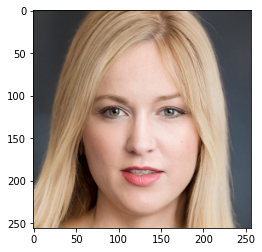

In [ ]:
url_faces = 'https://github.com/sony/nnabla-examples/blob/master/GANs/stylegan2/images/sample.png?raw=true'
faces_path = 'faces.png'
if not os.path.isfile(faces_path):
    tgt = urllib.request.urlopen(url_faces).read()
    with open(faces_path, mode='wb') as f:
        f.write(tgt)
        
img = cv2.imread('faces.png')
img = img[:, 512:768]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

Download a file to detect faces.

In [ ]:
# file to detect faces
url_cascade = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml'
cascade_path = 'haarcascade_frontalface_alt2.xml'
if not os.path.isfile(cascade_path):
    tgt = urllib.request.urlopen(url_cascade).read()
    with open(cascade_path, mode='wb') as f:
        f.write(tgt)

In [ ]:
cas = cv2.CascadeClassifier(cascade_path)

# Mask the image

Now let's define a function to mask the image.

In [ ]:
def make_masked_face_image(img, face, i):
    face = face[i]
    x, y, h, w = face[0], face[1], face[2], face[3]
    w_f = 0.2
    w_l = 0.8
    h_f = 0
    h_l = 1
    faces = []
    blocks = 3
    for i in range(blocks):
        for j in range(blocks):
            mask = np.zeros_like(img)
            
            w_1 = int((w_f+(i/blocks)*(w_l-w_f))*w)
            w_2 = int((w_f+((i+1)/blocks)*(w_l-w_f))*w)
            h_1 = int((h_f+(j/blocks)*(h_l-h_f))*h)
            h_2 = int((h_f+((j+1)/blocks)*(h_l-h_f))*h)
            
        
            pts = np.array(((x+w_1,y+h_1),(x+w_2,y+h_1),(x+w_2,y+h_2),(x+w_1,y+h_2)))
            cv2.fillConvexPoly(mask, pts, (255, 255, 255))
            face_ = np.where(mask == 255, img, mask)
            faces.append(face_)
    return faces


Let's take a look at how the face is extracted.

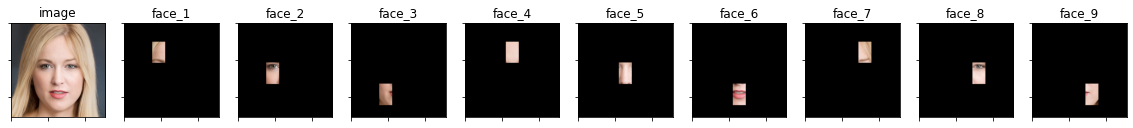

In [ ]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
faces = cas.detectMultiScale(gray_img)
masked_imgs = make_masked_face_image(img, faces,0)


images = {
    'image': img,
}
for i in range(len(masked_imgs)):
    key = "face_" + str(i+1)
    images[key] = masked_imgs[i]

row = 1
col = len(images)
fig, axes = plt.subplots(row, col, figsize=(20,20))

for i, (k, v) in enumerate(images.items()):
    axes[i].imshow(v)
    axes[i].set_title(k)
    axes[i].tick_params(labelbottom=False,
               labelleft=False,
               labelright=False,
               labeltop=False)


# Calculate the ITA
Now we calculate the ITA.<br>
In particular, we calculate the ITA for 9 masked images, then take the mean.

In [ ]:
masked_imgs = [extract_non_black(img) for img in masked_imgs] 
ita = calc_ita(masked_imgs)

/content/nnabla-examples/responsible_ai/face_evaluation/face_evaluation.py:36: RuntimeWarning: divide by zero encountered in true_divide
  ITA_img = (np.arctan((l_img-50)/b_img)*180)/np.pi


In [ ]:
print("Individual Typology Angle(ITA) : ", ita)

Individual Typology Angle(ITA) :  69.7


# ITAs for different faces
Lastly, Let's take a look at how the ITA is calculated for different faces.

/content/nnabla-examples/responsible_ai/face_evaluation/face_evaluation.py:36: RuntimeWarning: divide by zero encountered in true_divide
  ITA_img = (np.arctan((l_img-50)/b_img)*180)/np.pi


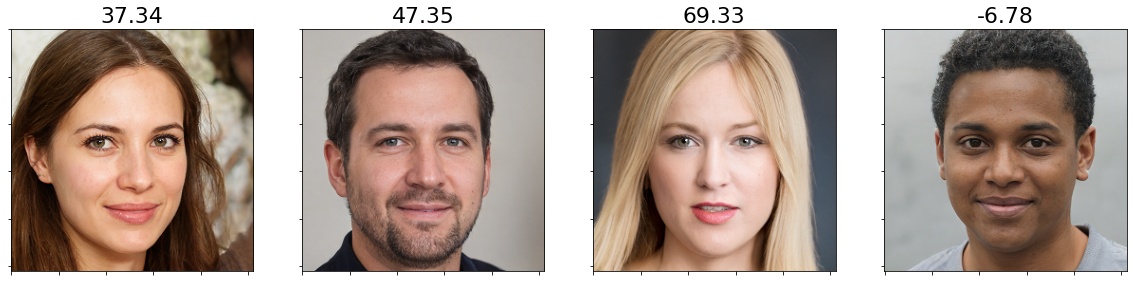

In [ ]:
img = cv2.imread('faces.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
faces = cas.detectMultiScale(img)
ITAs = []
for i in range(len(faces)):
    masked_img = make_masked_face_image(img, faces,i)
    masked_img = [extract_non_black(img) for img in masked_img] 
    ita = calc_ita(masked_img)
    ITAs.append(ita)

images = dict()
for i,j in enumerate(range(0,1024,256)):
    face_img = img[:, j:j+256]
    images[str(ITAs[i])] = face_img 
    
row = 1
col = len(images)
fig, axes = plt.subplots(row, col, figsize=(20,20))

for i, (k, v) in enumerate(images.items()):
    axes[i].imshow(v)
    axes[i].set_title(k, fontsize=22)
    axes[i].tick_params(labelbottom=False,
               labelleft=False,
               labelright=False,
               labeltop=False)
